In [1]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
%pylab inline 
import statsmodels.formula.api as smf
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [24]:
june = pd.read_csv( '201506-citibike-tripdata.csv')
stations = pd.read_csv( 'citibike-locations.csv')

In [5]:
june.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984,1
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997,1
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993,1
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981,1
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


In [6]:
june.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [21]:
# Grouping by Start and End Station
june_averaged = june.groupby(['start station id', 'end station id']).count()

In [22]:
june_averaged = june_averaged.reset_index()

In [23]:
juneGraph = nx.DiGraph()
for i in june_averaged.index:
    juneGraph.add_edge(june_averaged['start station id'][i], june['end station id'][i])

In [26]:
stations.head()

,the_geom,objectid,station_id,lat,lon,borough,name,cartodb_id,created_at,updated_at
0,0101000020E6100000899FCD819C7F52C097C807B43562...,1,72,40.767272,-73.993929,Manhattan,72,1,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
1,0101000020E61000009C8FB6336D8052C0078EEFB40B5C...,2,79,40.719116,-74.006667,Manhattan,79,2,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
2,0101000020E61000006C89E1AF028052C0A517FD7B075B...,3,82,40.711174,-74.000165,Manhattan,82,3,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
3,0101000020E61000003F96B982188052C0D584083FF25E...,4,116,40.741776,-74.001497,Manhattan,116,4,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
4,0101000020E61000005CA5D0796E8052C0067ADCDEA85D...,5,127,40.731724,-74.006744,Manhattan,127,5,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00


In [27]:
# pos ={}
# for c in stations.index:
#     pos[stations.station_id[c]] = (stations.lat[c], stations.lon[c])

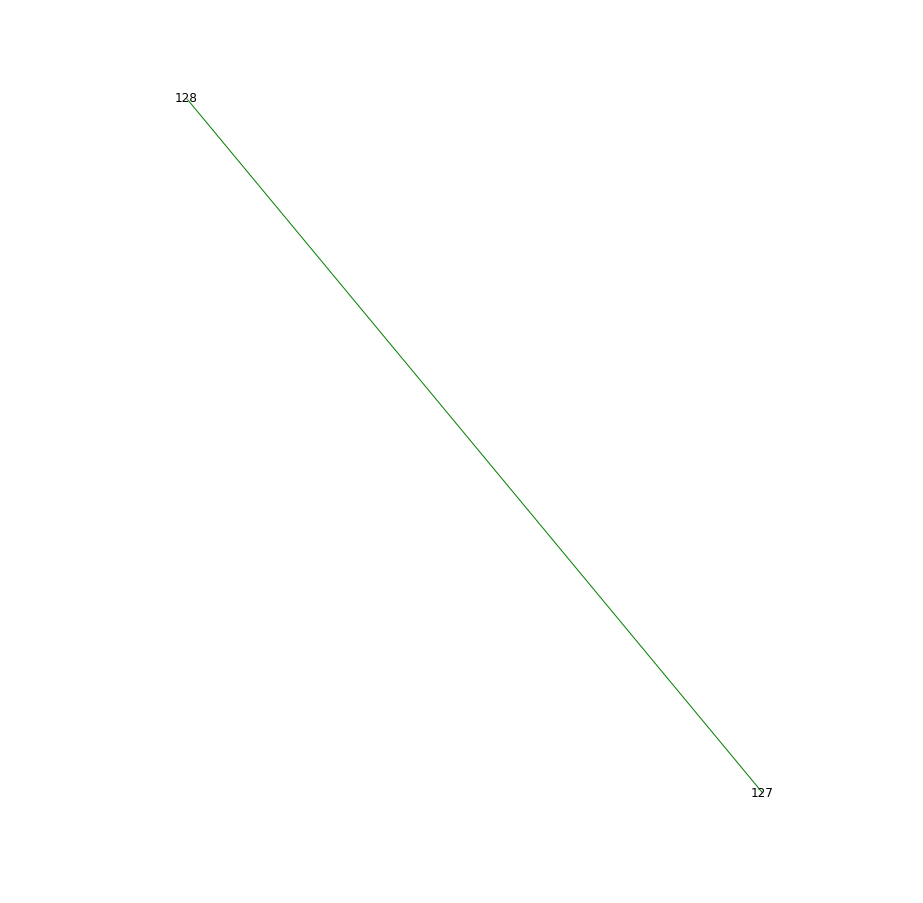

In [38]:
plt.figure(figsize = (12,12))
nx.draw(juneGraph.subgraph([127,128,129]),with_labels=True,arrows=False,node_size=1,width=1,edge_color='green')

In [33]:
juneGraph.subgraph?